# AppStat project
Rune Ekman (njf458)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from iminuit import Minuit
from iminuit.cost import LeastSquares


## Pendulum

Should we do the data processing for the laser and the tape measure separately? Troels said that it was quite hard to make them agree.

## Lengths

In [2]:
# Laser measurements from ceiling to floor  in meters
L_laser_s = [18.76, 18.76, 18.757, 18.759, 18.758, 18.758, 18.762, 18.758, 18.76, 18.758]
L_laser_s_toweight = [18.374, 18.378]
L_laser_m = [18.769, 18.764, 18.764, 18.763, 18.769, 18.759, 18.76, 18.758, 18.759, 18.759]
L_laser_r = [18.747, 18.749,18.780,18.774,18.790,18.784,18.771,18.780]
L_laser_a = [18.776,18.775,18.770,18.775,18.767,18.770]  

# Measured [to the top of weigth, to the bottom of the weigth] in meters
L_tape_s = [18.384, 18.416]
L_tape_m = [18.385, 18.415]
L_tape_r = [18.382, 18.419]
L_tape_a = [18.387, 18.416]

#From floor to weight in meters
floor_to_weight_r = [0.345, 0.345]
floor_to_weight_a = [0.346, 0.347, 0.347]
floor_to_weight = [0.345, 0.345,0.346, 0.347, 0.347]


#Height of weight?

#Hook on the tape measure in centimeters
tape_hook_s = [3, 2.95, 3, 3]

#Lets put it together in a matrix
laser_measurements = [L_laser_s, L_laser_m, L_laser_r, L_laser_a]
tape_measurements = [L_tape_s, L_tape_m, L_tape_r, L_tape_a]


In [53]:
#Averages, laser
#Søren
sørenl = np.mean(L_laser_s)
sørenlsig = np.std(L_laser_s)#/np.sqrt(len(L_laser_s))
#Manon
manonl = np.mean(L_laser_m)
manonlsig = np.std(L_laser_m)#/np.sqrt(len(L_laser_m))
#Rune
runel = np.mean(L_laser_r)
runelsig = np.std(L_laser_r)#/np.sqrt(len(L_laser_r))
#Andreas
andreasl = np.mean(L_laser_a)
andreaslsig = np.std(L_laser_a)#/np.sqrt(len(L_laser_a))

combinedl = np.array([sørenl,manonl,runel,andreasl])
combinedlsig = np.array([sørenlsig, manonlsig, runelsig, andreaslsig])

print("Lengths (Avg) of Søren, manon, rune, andreas",sørenl, manonl, runel, andreasl)
print("stds, same order ",sørenlsig, manonlsig, runelsig, andreaslsig)


#Calculating weighted average of all the lengths to the floor
weights = 1/combinedlsig**2
avglengthtobottom = np.sum(combinedl*weights)/np.sum(weights)
unctobottom = np.sqrt(1/np.sum(weights))
print("Weighted average for each person, to the bottom",avglengthtobottom, "+-", unctobottom)


#Calculating distance to COM
floortow = np.mean(floor_to_weight)
floortow_unc = np.std(floor_to_weight)/np.sqrt(len(floor_to_weight))

ceilingtow = np.mean(L_laser_s_toweight)
ceilingtow_unc = np.std(L_laser_s_toweight)/np.sqrt(len(L_laser_s_toweight))

#Distance to COM (weighted) using laser
L_laser = avglengthtobottom - floortow - (avglengthtobottom - floortow - ceilingtow)/2
L_laser_unc = np.sqrt((1/4)*unctobottom**2 + (3/2)**2 *floortow_unc**2 + (1/4)*ceilingtow_unc**2)

print("Distance to COM, as given by laser",L_laser,"+-", L_laser_unc)



Lengths (Avg) of Søren, manon, rune, andreas 18.759 18.762400000000003 18.771875 18.772166666666667
stds, same order  0.0014142135623735673 0.003903844259187956 0.014810785765785876 0.0033374973990832556
Weighted average for each person, to the bottom 18.76121809716788 +- 0.0012309605230866052
Distance to COM, as given by laser 18.39560904858394 +- 0.001113021092499934


In [56]:

#Calculating chi2 and chi2 probability (gives p value for these being in the same dist?)
chi2_L_laser = np.sum(((combinedl-avglengthtobottom) / combinedlsig)**2)
Ndof_laser = len(combinedl) - 1
chi2_prob_laser = stats.chi2.sf(chi2_L_laser, Ndof_laser)

print(chi2_L_laser, Ndof_laser ,chi2_prob_laser)


13.830872123346218 3 0.0031446416001589313


In [4]:
#Now with tape measure
L_tape_array = np.array([
    L_tape_s[1]-(L_tape_s[1]-L_tape_s[0]),
    L_tape_m[1]-(L_tape_m[1]-L_tape_m[0]),
    L_tape_r[1]-(L_tape_r[1]-L_tape_r[0]),
    L_tape_a[1]-(L_tape_a[1]-L_tape_a[0])
]) +0.001*np.mean(tape_hook_s)

L_tape = np.mean(L_tape_array)
L_tape_unc = np.std(L_tape_array)/2
print(L_tape, L_tape_unc)

18.3874875 0.0009013878188658673


## Timing

In [159]:
def ALL(file, bins, L, sig_L):
    
    #Defining our data, first for the period
    testfile1 = file #These files should include ONLY the counts and the times.
    
    testdata1 = np.genfromtxt(file, delimiter='\t', names=('n', 't_s'))
    testdata1 = testdata1[::2]
    constant = testdata1[0][1]
    for i in range(len(testdata1)):
        testdata1[i][0] = i
        testdata1[i][1] = testdata1[i][1] - constant
    n1,t1 = testdata1["n"], testdata1["t_s"] #Defines my two arrays from the data
    sigt1 = 0.08 #Our uncertainty in elapsed time.


    #Defining straight line function to be used in fitting
    def line(x,a,b):
        y= a*x+b 
        return y

    #Defining chi2 function for line:
    def chi2_owncalc_line(a,b) :
        y_fit = line(n1,a,b) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Performing the actual fit
    m = Minuit(chi2_owncalc_line,a=8, b=0)
    m.errordef = 1.0     # This is the definition for ChiSqaure fits
    m.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m.parameters :
        value, error = m.values[name], m.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value_line = m.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_line = len(n1) - m.nfit

    Prob_value = stats.chi2.sf(chi2_value_line, Ndof_value_line) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_line:.1f}   Ndof = {Ndof_value_line:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.5f}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12,8))
    ax_res = ax.inset_axes([0,-0.412,0.898,0.4]) #add the residual plot
    ax_gauss = ax.inset_axes([0.902,-0.412,0.098,0.4]) #add the gauss part

    ax.errorbar(n1, t1, yerr=sigt1, color='k', fmt='o', label="Data")
    ax.set_ylabel('Time elapsed (s)', fontsize=18)
    ax.set(xlim=(0, n1[-1]+np.ediff1d(n1)[0]), ylim=(0, t1[-1]+np.ediff1d(t1)[0]), xticklabels=[])
    #Enter the fit
    ax.plot(n1, line(n1, *m.values), label="Fit")

    fit_info = [
        #f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {Ndof_value_line:.0f} = {m.fval/Ndof_value_line:.1f}",
        f"$\\chi^2$={chi2_value_line:.1f} ,$n_\\mathrm{{dof}}$={Ndof_value_line:.0f}, Prob(Chi2,Ndof) = {Prob_value:5.3f}"
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

    ax.legend(title="\n".join(fit_info), frameon=False, loc="upper left")


    #Create residual plot
    residual = line(n1,m.values[0], m.values[1]) - t1
    ax_res.scatter(n1,residual, color="k")
    ax_res.axhline(y=0, linestyle="dashed", color="red")
    ax_res.set_ylabel("Residuals", fontsize=18)
    ax_res.set_xlabel('Timing measurement number', fontsize=18)

    
    #Calculating residual histogram stuff

    xmin=min(residual)-0.01
    xmax=max(residual)+0.01
    Nbins = bins
    binwidth = (xmax-xmin)/Nbins #needed for normalization, see the Gauss function
    counts, bin_edges = np.histogram(residual, bins=Nbins, range=(xmin,xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts

    # Making sure non-zero bins
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy=np.sqrt(y)

    #Creating Gaussian fit
    #First defining the Gauss function
    def gauss_pdf(val,A,mu,sigma):
        return len(y) *binwidth* A*stats.norm.pdf(val,mu,sigma)

    # Defining Chi2 calculation:
    def chi2_owncalc(A, mu, sigma) :
        y_fit = gauss_pdf(x, A, mu, sigma)
        chi2 = np.sum(((y - y_fit) / sy)**2)
        return chi2

    #Performing the actual fit
    minuit_chi2 = Minuit(chi2_owncalc,A=5, mu=0, sigma=0.05)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('RESIDUAL GAUSSIAN VALUES')
    if (not minuit_chi2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    N_NotEmptyBin = np.sum(y > 0)
    Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


    
    #Plotting histogram of residuals
    ax_gauss.hist(residual, bins=Nbins, orientation="horizontal", histtype='step', linewidth=2, color='red', label='Residuals')
    x_axis = np.linspace(xmin, xmax, 1000)
    ax_gauss.plot(gauss_pdf(x_axis, *minuit_chi2.values[:]),x_axis, '-r', label='Chi2 fit model result') 
    
    ax_gauss.set(xlim=ax_gauss.get_xlim()[::-1],yticklabels=[],ylabel='Residual histogram')
    ax_gauss.yaxis.set_label_position("right")
    #ax_gauss.legend()


    def g(T, L, sig_T, sig_L):
        g=L*(2*np.pi/(T))**2
        sig_g = np.sqrt((2*np.pi/T)**4 * sig_L**2 + ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
        return g, sig_g
    
    
    print('g value =', g(m.values['a'], 18.4, m.errors['a'], 0.001))
    
   


PERIOD VALUES
Fit value: a = 8.59434 +/- 0.00363
Fit value: b = 0.08244 +/- 0.03619
Chi2 value: 10.3   Ndof = 16    Prob(Chi2,Ndof) = 0.84897
RESIDUAL GAUSSIAN VALUES
Fit value: A = 3.62711 +/- 1.17603
Fit value: mu = 0.00386 +/- 0.03681
Fit value: sigma = 0.07517 +/- 0.03429
Chi2 value: 1.7   Ndof = 2    Prob(Chi2,Ndof) = 0.424
g value = (9.834514659949626, 0.008335054268432536)


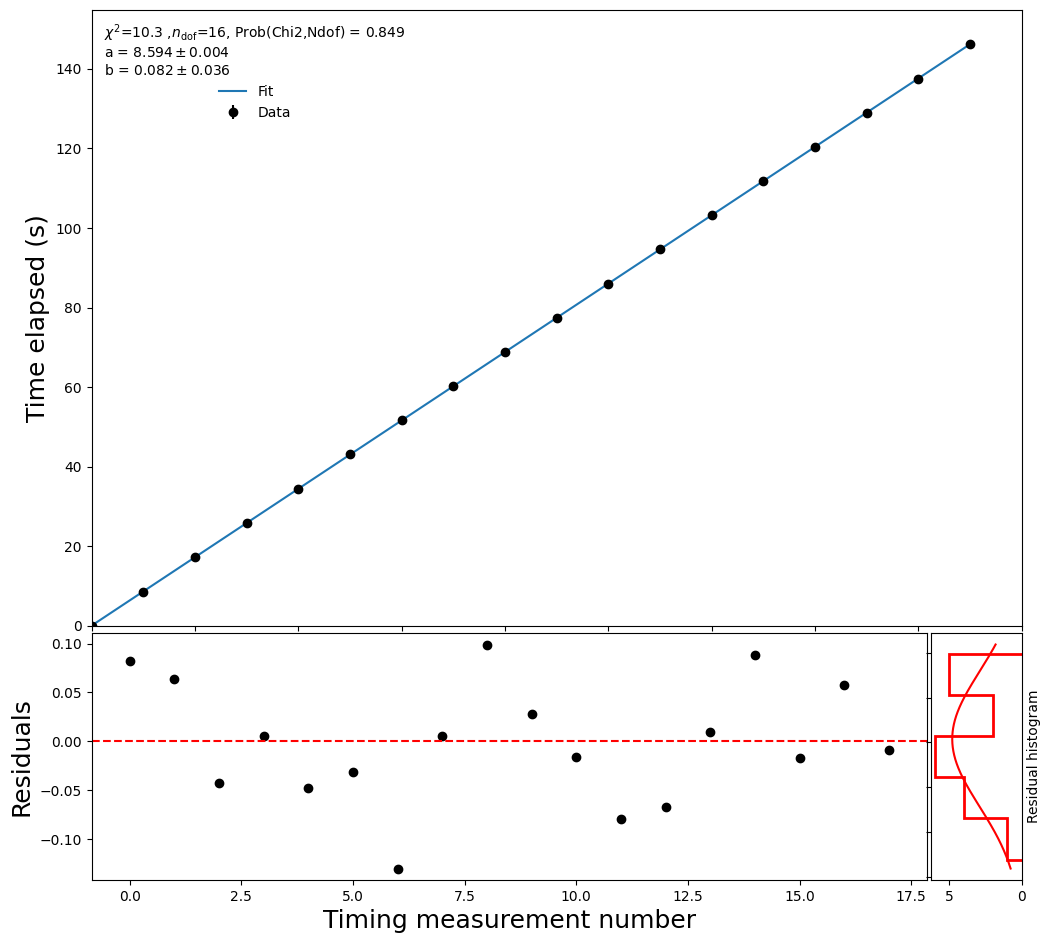

In [161]:
ALL("rune3.dat", 5, L= L_laser, sig_L= L_laser_unc)    

PERIOD VALUES
Fit value: a = 8.60410 +/- 0.00396
Fit value: b = 0.02835 +/- 0.03715
Chi2 value: 3.1   Ndof = 15    Prob(Chi2,Ndof) = 0.99954
RESIDUAL GAUSSIAN VALUES
Fit value: A = 3.59785 +/- 1.06128
Fit value: mu = -0.00199 +/- 0.01438
Fit value: sigma = 0.04479 +/- 0.01820
Chi2 value: 0.9   Ndof = 2    Prob(Chi2,Ndof) = 0.642
g value = (9.812205528098762, 0.009049125358689182)


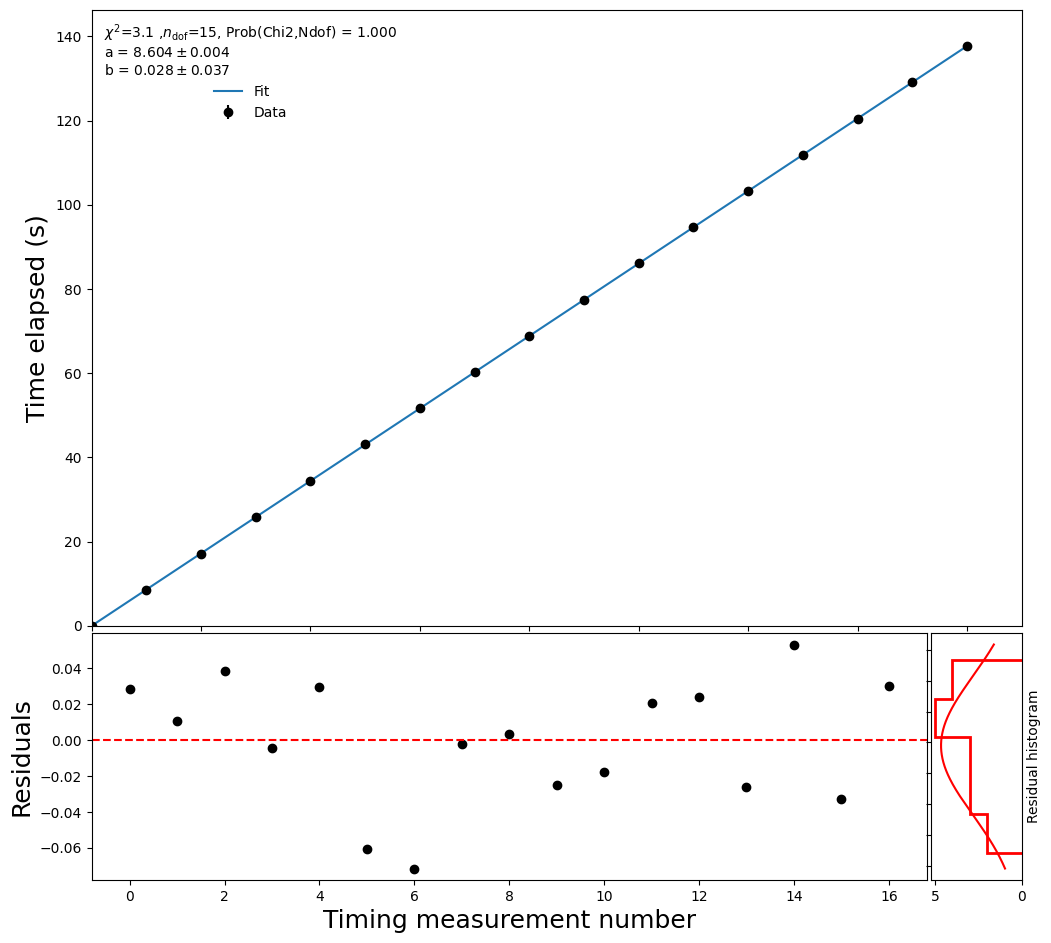

In [162]:
ALL("rune4.dat", 5, L= L_laser, sig_L= L_laser_unc)    

# Damped?
Trying to calculate g from damped pendulum. Trying out different things.

In [51]:
def ALL_weird(file, bins):
    
    #Defining our data, first for the period
    testfile1 = file #These files should include ONLY the counts and the times.
    
    testdata1 = np.genfromtxt(file, delimiter='\t', names=('n', 't_s'), skip_header=1)
    #testdata1 = testdata1[::2]
    constant = testdata1[0][1]
    for i in range(len(testdata1)):
        testdata1[i][0] = i
        testdata1[i][1] = testdata1[i][1] - constant
    n1,t1 = testdata1["n"], testdata1["t_s"] #Defines my two arrays from the data
    sigt1 = 0.08 #Our uncertainty in elapsed time.


    #Defining straight line function to be used in fitting
    def line(x,a,b,k):
        y= a*x+b +k*x**2
        return y

    #Defining chi2 function for line:
    def chi2_owncalc_line(a,b,k) :
        y_fit = line(n1,a,b,k) #observe that we in this function input our data (n1 and t1)!!
        chi2 = np.sum(((t1 - y_fit) / sigt1)**2)
        return chi2
    
    #Performing the actual fit
    m = Minuit(chi2_owncalc_line,a=8, b=0, k=0.01)
    m.errordef = 1.0     # This is the definition for ChiSqaure fits
    m.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('PERIOD VALUES')
    if (not m.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in m.parameters :
        value, error = m.values[name], m.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value_line = m.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value_line = len(n1) - m.nfit

    Prob_value = stats.chi2.sf(chi2_value_line, Ndof_value_line) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value_line:.1f}   Ndof = {Ndof_value_line:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")
    
    # Plotting
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8), gridspec_kw={'height_ratios':[4,1]}, sharex=True)
    ax[0].errorbar(n1, t1, yerr=sigt1, color='k', fmt='o', label="Data")
    ax[0].set_xlabel('Timing measurement number', fontsize=18)
    ax[0].set_ylabel('Time elapsed (s)', fontsize=18)
    ax[0].set(xlim=(0, n1[-1]+np.ediff1d(n1)[0]), ylim=(0, t1[-1]+np.ediff1d(t1)[0]))
    #Enter the fit
    ax[0].plot(n1, line(n1, *m.values), label="Fit")

    fit_info = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {Ndof_value_line:.0f} = {m.fval/Ndof_value_line:.1f}",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

    ax[0].legend(title="\n".join(fit_info), frameon=False)


    #Create residual plot
    residual = line(n1,*m.values) - t1
    ax[1].scatter(n1,residual, color="k")
    ax[1].axhline(y=0, linestyle="dashed", color="red")
    ax[1].set_ylabel("Residuals", fontsize=18)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    xmin=-0.2
    xmax=0.2
    Nbins = bins
    counts, bin_edges = np.histogram(residual, bins=Nbins, range=(xmin,xmax))
    x = (bin_edges[1:] + bin_edges[:-1])/2
    y = counts

    # Making sure non-zero bins
    x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
    y = counts[counts>0]
    sy=np.sqrt(y)


    #Plotting histogram
    hist = ax.hist(residual, bins=Nbins, histtype='step', linewidth=2, color='red', label='Residuals')

    #Creating Gaussian fit
    #First defining the Gauss function
    def gauss_pdf(val,A,mu,sigma):
        return A*stats.norm.pdf(val,mu,sigma)


    # Defining Chi2 calculation:
    def chi2_owncalc(A, mu, sigma) :
        y_fit = gauss_pdf(x, A, mu, sigma)
        chi2 = np.sum(((y - y_fit) / sy)**2)
        return chi2

    #Performing the actual fit
    minuit_chi2 = Minuit(chi2_owncalc,A=5, mu=0, sigma=0.05)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

    print('RESIDUAL GAUSSIAN VALUES')
    if (not minuit_chi2.fmin.is_valid) :
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

    # Loop to get both parameter values and uncertainties:
    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    N_NotEmptyBin = np.sum(y > 0)
    Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

    x_axis = np.linspace(xmin, xmax, 1000)
    ax.plot(x_axis, gauss_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 
    ax.legend()

    def g(T, L, sig_T, sig_L):
        g=L*(2*np.pi/(2*T))**2
        sig_g = np.sqrt((2*np.pi/T)**4 * sig_L**2 + ((2*L*(2*np.pi)**2)/T**3)**2 * sig_T**2)
        return g, sig_g
    
    
    print('g value =', g(m.values['a'], 18.4, m.errors['a'], 0.001))
 

PERIOD VALUES
Fit value: a = 4.11204 +/- 0.00317
Fit value: b = -0.82959 +/- 0.03293
Fit value: k = -0.00059 +/- 0.00006
Chi2 value: 4983.5   Ndof = 46    Prob(Chi2,Ndof) = 0.000
RESIDUAL GAUSSIAN VALUES
Fit value: A = 4.32208 +/- 33.36789
Fit value: mu = -0.00634 +/- 0.01773
Fit value: sigma = 0.03038 +/- 0.03985
Chi2 value: 4.0   Ndof = 1    Prob(Chi2,Ndof) = 0.046
g value = (10.739991965290063, 0.06634332856341595)


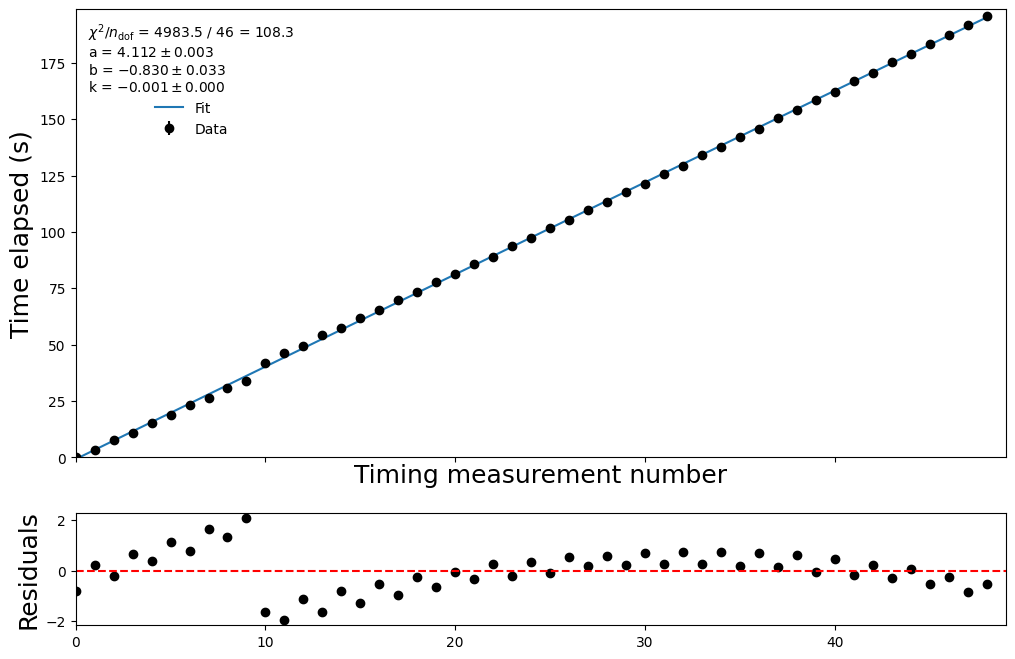

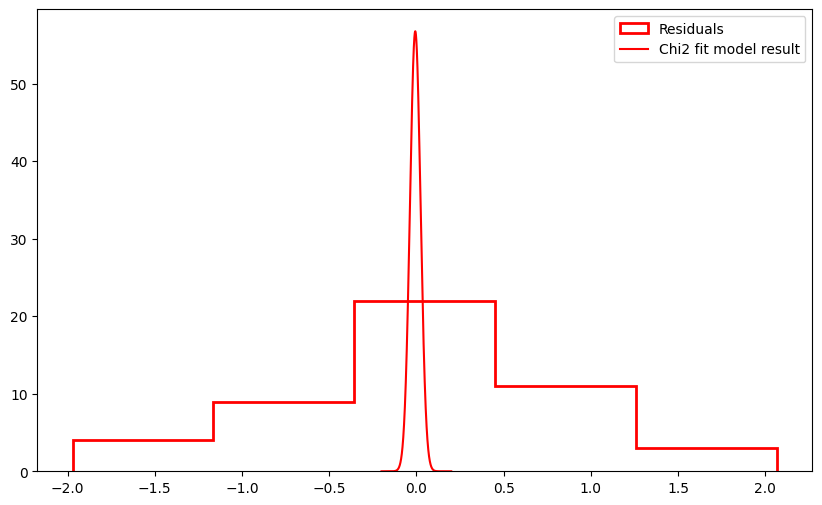

In [62]:
ALL_weird("manon1.dat", 5)